In [1]:
# Problem 1

In [149]:
!pip install d2l==1.0.3 #Install new library for use

241938.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [150]:
pip install --upgrade pip #Upgrade the Pip

241945.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.


In [33]:
%matplotlib inline
import torch
from d2l import torch as d2l

In [34]:
class LinearRegressionScratch(d2l.Module): # Set up a new class from Scratch
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=1000): # Define the Standard Deviation to be 0.01
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.zeros((num_inputs, 1), requires_grad=True) #Define the weight value
        self.b = torch.zeros(1, requires_grad=True) # Define the bias value

In [35]:
# Define our model, relating its input and parameters to its output
@d2l.add_to_class(LinearRegressionScratch)  
def forward(self, X):
    return torch.matmul(X, self.w) + self.b # Linear addition of weights to biases using broadcasting

In [36]:
# Defining the loss function
@d2l.add_to_class(LinearRegressionScratch) 
def loss(self, y_hat, y):
    l = (y_hat - y) ** 2 / 2 # Use square error loss function
    return l.mean() # Return averaged loss value among all examples 

In [37]:
# Defining the optimization algorithm
class SGD(d2l.HyperParameters):  #@save
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr): # applies the update, given a set of parameters, a learning rate lr
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_() # The zero_grad method sets all gradients to 0

In [38]:
# Configures optimizers, returns an instance of the SGD class
@d2l.add_to_class(LinearRegressionScratch)  #@save
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

In [39]:
# Set up code to train the data
@d2l.add_to_class(d2l.Trainer) 
def prepare_batch(self, batch):
    return batch

In [40]:
# Main Training Loop
@d2l.add_to_class(d2l.Trainer)  
def fit_epoch(self): # Define the method for training one epoch
    self.model.train() # Set the model to training mode

    for batch in self.train_dataloader: # Iterate over batches in the training data loader
        loss = self.model.training_step(self.prepare_batch(batch)) # Compute the loss for the current batch
        self.optim.zero_grad() # Zero out the gradients stored in the optimizer
        with torch.no_grad(): # Perform operations without tracking gradients
            loss.backward() # Compute gradients and perform a backward pass
            if self.gradient_clip_val > 0: # Clip gradients if specified
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step() # Update the model parameters using the optimizer
        self.train_batch_idx += 1 # Increment the training batch index

    if self.val_dataloader is None: # Check if a validation data loader is provided
        return

    self.model.eval() # Set the model to evaluation mode

    for batch in self.val_dataloader: # Iterate over batches in the validation data loader
        with torch.no_grad(): # Perform operations without tracking gradients
            self.model.validation_step(self.prepare_batch(batch)) # Compute the validation loss for the current batch
        self.val_batch_idx += 1 # Increment the validation batch index


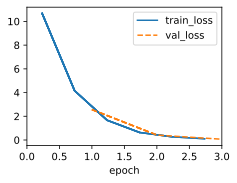

In [41]:
model = LinearRegressionScratch(2, lr=0.03) # Model learning rate 0.03, inputs is 2
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2) # Sets weights and Biases
trainer = d2l.Trainer(max_epochs=3) # Defines the maximum number of epochs
trainer.fit(model, data) # Fits the data

In [42]:
# Compare training parameters to those learned in training loop
with torch.no_grad():
    print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
    print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.1387, -0.2283])
error in estimating b: tensor([0.2491])


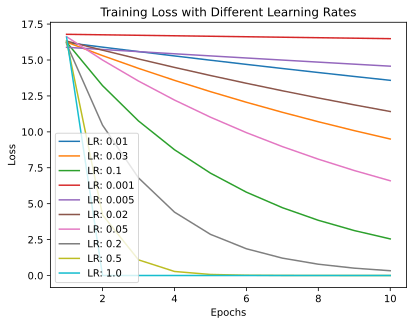

In [45]:
# Test different learning rates for epochs vs loss function
import matplotlib.pyplot as plt

# Define different values for learning rates
learning_rates = [0.01, 0.03, 0.1] + [0.001, 0.005, 0.02, 0.05, 0.2, 0.5, 1.0]
max_epochs = 10

# Loop over learning rates
for lr in learning_rates:
    model = LinearRegressionScratch(2, lr=lr)
    data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
    
    losses = []

    # Training loop
    for epoch in range(1, max_epochs + 1):
        y_hat = model(data.X)
        loss = model.loss(y_hat, data.y)

        # Compute gradients and perform a backward pass
        loss.backward()

        # Update model parameters using the optimizer
        with torch.no_grad():
            model.w -= model.lr * model.w.grad
            model.b -= model.lr * model.b.grad

            # Zero the gradients for the next iteration
            model.w.grad.zero_()
            model.b.grad.zero_()

        losses.append(loss.item())

    # Plot the training loss curve
    plt.plot(range(1, max_epochs + 1), losses, label=f'LR: {lr}')

# Add labels and legend to the plot
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss with Different Learning Rates')
plt.legend()
plt.show()


In [41]:
# a). Setting the weights to zero, the model does not change and the algorithim works well. 
# Additionally, initializing the parameters with sigma = 1000 instead of sigma = 0.01 does not change the effectiveness of the algorithm

In [24]:
#b). The greater the learning rate, the faster the loss function value is dropping However, too great and the function overshoots. 
# As the maximum number of epochs is increased, the training error is decreased to a point, but there is the potential of 
# overfitting the data, which is not good for generalizing the model.